In [134]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import igraph

In [112]:
m_graph = pickle.load(open('./data/icwsm_polarization/mention_igraph.pickle', "rb"))
r_graph = pickle.load(open('./data/icwsm_polarization/retweet_igraph.pickle', "rb"))

In [81]:
r_graph.edge_attributes()

['tags', 'type', 'urls', 'time']

In [83]:
r_graph.get_edgelist()[0:10]

[(12464, 7349),
 (6820, 12569),
 (4336, 15967),
 (16397, 5927),
 (8829, 13851),
 (17673, 5153),
 (5467, 3944),
 (9864, 2813),
 (15781, 5425),
 (1195, 6940)]

In [86]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [103]:
def reverse_igraph_edges(graph):
    edge_attributes = graph.edge_attributes()
    attributes_dict = {attr:r_graph.es[attr] for attr in edge_attributes}
    
    reversed_edges = [tuple(reversed(edge)) for edge  in graph.get_edgelist()]
    
    graph.es.delete()
    
    graph.add_edges(reversed_edges)
    
    for attr in edge_attributes:
        r_graph.es[attr] = edge_attributes_dict[attr]


In [106]:
reverse_igraph_edges(r_graph)

In [91]:
r_graph.get_edgelist()[0:10]

[(7349, 12464),
 (12569, 6820),
 (15967, 4336),
 (5927, 16397),
 (13851, 8829),
 (5153, 17673),
 (3944, 5467),
 (2813, 9864),
 (5425, 15781),
 (6940, 1195)]

In [92]:
r_graph.es["tags"][0:10]

[['#tcot', '#tlot'],
 ['#p2', '#progca', '#casen'],
 ['#dems', '#ocra', '#p2', '#s'],
 ['#tcot'],
 ['#teaparty', '#tcot', '#alaska', '#ak'],
 ['#desen', '#tcot', '#teaparty'],
 ['#cuba', '#obama', '#eeuu'],
 ['#ocra', '#tcot'],
 ['#dems'],
 ['#tcot', '#teaparty', '#sgp']]

In [3]:
m_layout = m_graph.layout("large")

In [4]:
r_layout=r_graph.layout("large")

In [5]:
m_graph.vs["size"]=4
m_graph.es["arrow_size"]=0.3
m_graph.es["width"]=0.5
m_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
m_graph.vs["color"] = [color_dict[cluster] for cluster in m_graph.vs["cluster"]]
m_out = igraph.plot(m_graph, layout=m_layout)

m_out.save("mention_network.png")

In [76]:
r_graph.vs["size"]=4
r_graph.es["arrow_size"]=0.3
r_graph.es["width"]=0.5
r_graph.es["color"]="#b3b3b3"
color_dict = {"left": "#0015bc", "right": "#e91d0e", "-": "grey"}
r_graph.vs["color"] = [color_dict[cluster] for cluster in r_graph.vs["cluster"]]
r_out = igraph.plot(r_graph, layout=r_layout)

r_out.save("retweet_network.png")

In [292]:
def plot_edge_distribution(ax, graph, mode, g_type):
    if (mode=="out" or mode=="in"):
        x = list(range(0, graph.maxdegree(mode=mode) + 1))
        y =[graph.degree(mode=mode).count(i) for i in x]

        ax.loglog(x, y, "k.")
        ax.set_xlabel("number of {}".format(g_type))
        ax.set_ylabel("number of users")

In [293]:
width = 12
height = width / 1.618

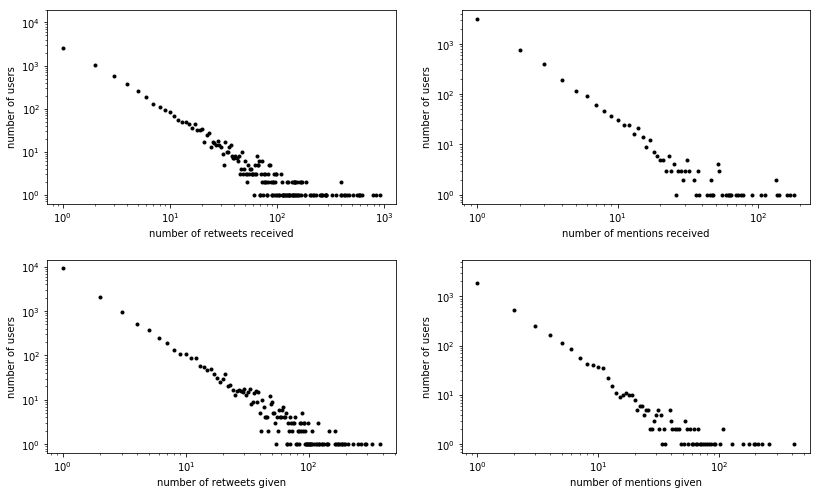

In [294]:
fig, ax = plt.subplots(2,2, figsize=(width, height))
fig.tight_layout(pad=2.5)
plot_edge_distribution(ax[0, 0], r_graph, "out", "retweets received")
plot_edge_distribution(ax[1, 0], r_graph, "in", "retweets given")
plot_edge_distribution(ax[0, 1], m_graph, "out", "mentions received")
plot_edge_distribution(ax[1, 1], m_graph, "in", "mentions given")
fig.savefig("edge_distributions.png", quality=95)